# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-05-21'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2016-05-23 A        41.823692   44.570000   44.959999   44.529999   44.889999   
           AAL      30.493265   31.730000   32.290001   31.700001   32.029999   
           AAPL     22.142420   24.107500   24.297501   23.917500   23.967501   
           ABBV     42.024982   59.299999   59.840000   59.130001   59.750000   
           ABT      32.254204   37.369999   37.750000   37.270000   37.720001   
...                       ...         ...         ...         ...         ...   
2024-05-20 XYL     145.389587  145.770004  145.929993  143.389999  143.580002   
           YUM     138.986984  139.669998  141.619995  139.240005  141.520004   
           ZBH     119.050003  119.050003  120.089996  118.940002  120.050003   
           ZBRA    320.160004  320.160004  320.540009  316.239990  316.239990   
           ZTS     174.389999  174.389999  174.710007  172.190002  173.589996   

                        volume  
date       ticker               
2016-05-23 A         1689700.0  
           AAL       6498400.0  
           AAPL    152074400.0  
           ABBV      6468900.0  
           ABT       7126700.0  
...                        ...  
2024-05-20 XYL       1243500.0  
           YUM       1227400.0  
           ZBH       1152700.0  
           ZBRA       332000.0  
           ZTS       2254400.0  

[992402 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-05-23 A        41.823692   44.570000   44.959999   44.529999   44.889999   
           AAL      30.493265   31.730000   32.290001   31.700001   32.029999   
           AAPL     22.142420   24.107500   24.297501   23.917500   23.967501   
           ABBV     42.024982   59.299999   59.840000   59.130001   59.750000   
           ABT      32.254204   37.369999   37.750000   37.270000   37.720001   
...                       ...         ...         ...         ...         ...   
2024-05-20 XYL     145.389587  145.770004  145.929993  143.389999  143.580002   
           YUM     138.986984  139.669998  141.619995  139.240005  141.520004   
           ZBH     119.050003  119.050003  120.089996  118.940002  120.050003   
           ZBRA    320.160004  320.160004  320.540009  316.239990  316.239990   
           ZTS     174.389999  174.389999  174.710007  172.190002  173.589996   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-05-23 A         1689700.0         -0.001888        NaN       NaN   
           AAL       6498400.0         -0.000764        NaN       NaN   
           AAPL    152074400.0         -0.002299        NaN       NaN   
           ABBV      6468900.0         -0.047766        NaN       NaN   
           ABT       7126700.0         -0.009384        NaN       NaN   
...                        ...               ...        ...       ...   
2024-05-20 XYL       1243500.0          0.000094  74.578518  4.853198   
           YUM       1227400.0          0.000018  53.814515  4.896155   
           ZBH       1152700.0          0.000019  42.438420  4.784309   
           ZBRA       332000.0          0.000033  61.608483  5.648095   
           ZTS       2254400.0          0.000097  59.399892  5.017730   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-05-23 A            NaN       NaN       NaN       NaN      70.669493  
           AAL          NaN       NaN       NaN       NaN     198.157434  
           AAPL         NaN       NaN       NaN       NaN    3367.295208  
           ABBV         NaN       NaN       NaN       NaN     271.855409  
           ABT          NaN       NaN       NaN       NaN     229.866034  
...                     ...       ...       ...       ...            ...  
2024-05-20 XYL     4.929990  5.006781  0.425066  2.210362     180.791952  
           YUM     4.934532  4.972909  0.598987  0.107135     170.592624  
           ZBH     4.799904  4.815500 -0.639331 -0.423719     137.228939  
           ZBRA    5.737909  5.827722 -0.094331  0.933438     106.293121  
           ZTS     5.108752  5.199774  0.886068  1.137960     393.144815  

[992402 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-06-30 A           99.655613   41.736313 -1.181780  3.818078  3.721142   
           AAL        351.266383   27.206570  0.720428  3.531905  3.253283   
           AAPL      3129.251319   21.951822 -1.218906  3.183039  3.100777   
           ABBV       418.335105   43.874660 -0.996399  3.833325  3.744297   
           ABT        338.847582   33.928619 -1.156655  3.565836  3.488460   
...                          ...         ...       ...       ...       ...   
2024-05-31 XYL        195.244609  145.389587  0.425066  5.006781  4.853198   
           YUM        296.567547  138.986984  0.598987  4.972909  4.896155   
           ZBH        170.274249  119.050003 -0.639331  4.815500  4.784309   
           ZBRA       102.979838  320.160004 -0.094331  5.827722  5.648095   
           ZTS        480.225038  174.389999  0.886068  5.199774  5.017730   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-06-30 A       3.769610         -0.000631 -0.500373  47.124782  
           AAL     3.392594          0.000214 -1.968533  41.670600  
           AAPL    3.141908         -0.001929 -0.459339  46.922208  
           ABBV    3.788811         -0.045187 -0.495491  55.572392  
           ABT     3.527148         -0.006377 -0.358801  57.898781  
...                     ...               ...       ...        ...  
2024-05-31 XYL     4.929990          0.000094  2.210362  74.578518  
           YUM     4.934532          0.000018  0.107135  53.814515  
           ZBH     4.799904          0.000019 -0.423719  42.438420  
           ZBRA    5.737909          0.000033  0.933438  61.608483  
           ZTS     5.108752          0.000097  1.137960  59.399892  

[47341 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-05-31 AAL      46.985195  0.553128  3.886832  3.763660  3.825246   
           AAPL     35.748730 -1.192454  3.637560  3.567802  3.602681   
           ABBV     48.592541 -1.607800  3.921028  3.889572  3.905300   
           ABT      40.407558 -1.352614  3.719186  3.659323  3.689255   
           ACN     112.053139 -1.231195  4.725428  4.687239  4.706334   
...                       ...       ...       ...       ...       ...   
2024-05-31 VZ       40.119999 -0.814034  3.732630  3.681999  3.707314   
           WFC      60.700001 -0.221381  4.149398  4.086552  4.117975   
           WMT      64.180000  1.400173  4.171512  4.064986  4.118249   
           XOM     118.669998  0.410244  4.803762  4.745082  4.774422   
           ZTS     174.389999  0.886068  5.199774  5.017730  5.108752   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-05-31 AAL            -0.000056  1.299624  60.617012  
           AAPL           -0.002044 -0.009731  61.065267  
           ABBV           -0.037005 -0.161784  54.399932  
           ABT            -0.004774 -0.056035  64.674752  
           ACN            -0.003927  0.045336  62.532098  
...                             ...       ...        ...  
2024-05-31 VZ              0.000027  0.131801  51.690097  
           WFC             0.000184  0.978653  59.030299  
           WMT             0.000090  1.609436  68.971172  
           XOM             0.000033  0.317213  57.321776  
           ZTS             0.000097  1.137960  59.399892  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-05-31 AAL      42.618008  1.369931  3.801628  3.728982  3.765305   
           AAPL     44.410900 -1.030952  3.844051  3.784342  3.814196   
           ABBV     75.292389  0.480660  4.422443  4.323378  4.372910   
           ABT      55.550396 -0.777935  4.066919  3.981285  4.024102   
           ACN     142.810822 -0.857825  4.982194  4.942734  4.962464   
...                       ...       ...       ...       ...       ...   
2024-05-31 VRTX    445.869995  1.048088  6.111935  5.946340  6.029137   
           VZ       40.119999 -0.814034  3.732630  3.681999  3.707314   
           WFC      60.700001 -0.221381  4.149398  4.086552  4.117975   
           WMT      64.180000  1.400173  4.171512  4.064986  4.118249   
           XOM     118.669998  0.410244  4.803762  4.745082  4.774422   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-05-31 AAL             0.000660 -0.580034  45.114556   0.016581   
           AAPL           -0.001003  0.137939  59.945462   0.135124   
           ABBV           -0.032834  0.074994  46.193244   0.024754   
           ABT            -0.004457  0.281438  54.184926   0.058490   
           ACN            -0.002942 -0.015917  53.108622   0.030027   
...                             ...       ...        ...        ...   
2024-05-31 VRTX            0.000057  2.276893  72.353992   0.135078   
           VZ              0.000027  0.131801  51.690097   0.015953   
           WFC             0.000184  0.978653  59.030299   0.029146   
           WMT             0.000090  1.609436  68.971172   0.085125   
           XOM             0.000033  0.317213  57.321776   0.011532   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-05-31 AAL     -0.083533  -0.069961  -0.023688  -0.002302   -0.008097  
           AAPL     0.057391   0.017418   0.015402   0.015909    0.018245  
           ABBV     0.027693  -0.047916   0.006367   0.033601    0.037166  
           ABT      0.015781   0.008199   0.016325   0.022849    0.026878  
           ACN      0.011705  -0.008131   0.009999   0.021704    0.020418  
...                      ...        ...        ...        ...         ...  
2024-05-31 VRTX     0.032787   0.019526   0.038808   0.027807    0.027078  
           VZ      -0.014286   0.006206   0.013157   0.021450    0.015988  
           WFC      0.026302   0.031717   0.054986   0.046252    0.038318  
           WMT      0.034571   0.033083   0.037866   0.020146    0.023768  
           XOM      0.014494   0.046048   0.027280   0.010224    0.015470  

[10504 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.030027
...                   ...     ...     ...     ...    ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.017464

[10362 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [7]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.015   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.015   0.030027
...                   ...     ...     ...     ...    ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.003  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.003   0.017464

[10327 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [8]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-05-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.445515 -1.035401  0.572179  0.109526 -0.072877
           WFC     1.099293  0.259486  1.225701 -0.520460 -0.781068
           WMT     0.609516  0.128328 -0.665654  0.617155  0.467717
           XOM     0.792348 -0.105848  0.684730  0.876951  0.323337

[10327 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10297 entries, (Timestamp('2018-05-31 00:00:00'), 'AAL') to (Timestamp('2024-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10297 non-null  float64
 1   bb_high           10297 non-null  float64
 2   bb_low            10297 non-null  float64
 3   bb_mid            10297 non-null  float64
 4   garman_klass_vol  10297 non-null  float64
 5   macd              10297 non-null  float64
 6   rsi               10297 non-null  float64
 7   return_1m         10297 non-null  float64
 8   return_2m         10297 non-null  float64
 9   return_3m         10297 non-null  float64
 10  return_6m         10297 non-null  float64
 11  return_9m         10297 non-null  float64
 12  return_12m        10297 non-null  float64
 13  Mkt-RF            10297 non-null  float64
 14  SMB               10297 non-null  float64
 15  HML        

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

### Apply pre-defined centroids.

In [10]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.369931  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.030952  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.480660  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.777935  4.066919  3.981285  4.024102         -0.004457   
           ACN    -0.857825  4.982194  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.048088  6.111935  5.946340  6.029137          0.000057   
           VZ     -0.814034  3.732630  3.681999  3.707314          0.000027   
           WFC    -0.221381  4.149398  4.086552  4.117975          0.000184   
           WMT     1.400173  4.171512  4.064986  4.118249          0.000090   
           XOM     0.410244  4.803762  4.745082  4.774422          0.000033   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-05-31 AAL    -0.580034  45.114556   0.016581  -0.083533  -0.069961   
           AAPL    0.137939  59.945462   0.135124   0.057391   0.017418   
           ABBV    0.074994  46.193244   0.024754   0.027693  -0.047916   
           ABT     0.281438  54.184926   0.058490   0.015781   0.008199   
           ACN    -0.015917  53.108622   0.030027   0.011705  -0.008131   
...                     ...        ...        ...        ...        ...   
2024-05-31 VRTX    2.276893  72.353992   0.135078   0.032787   0.019526   
           VZ      0.131801  51.690097   0.015953  -0.014286   0.006206   
           WFC     0.978653  59.030299   0.029146   0.026302   0.031717   
           WMT     1.609436  68.971172   0.085125   0.034571   0.033083   
           XOM     0.317213  57.321776   0.011532   0.014494   0.046048   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-05-31 AAL     -0.023688  -0.002302   -0.008097  1.228687  1.420822   
           AAPL     0.015402   0.015909    0.018245  1.318208 -0.345319   
           ABBV     0.006367   0.033601    0.037166  0.462765  0.533207   
           ABT      0.016325   0.022849    0.026878  0.800425 -0.143508   
           ACN      0.009999   0.021704    0.020418  1.216364 -0.187452   
...                      ...        ...         ...       ...       ...   
2024-05-31 VRTX     0.038808   0.027807    0.027078  0.504107  0.063471   
           VZ       0.013157   0.021450    0.015988  0.471917 -0.433146   
           WFC      0.054986   0.046252    0.038318  1.074879 -0.085147   
           WMT      0.037866   0.020146    0.023768  0.604001 -0.391737   
           XOM      0.027280   0.010224    0.015470  1.083539  0.183977   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-05-31 AAL     0.459890  0.073156  0.802911        1  
           AAPL   -0.615990  0.437066  0.603375        2  
           ABBV   -0.186527  0.532580  0.419903        1  
           ABT    -0.456879  0.255552  0.954193        2  
           ACN    -0.263761  0.311159  0.113143        2  
...                     ...       ...       ...      ...  
2024-05-31 VRTX   -0.884563  0.103392  0.854965        3  
           VZ      0.196197  0.235408  0.276491        1  
           WFC     1.551623 -0.760983 -0.811309        2  
           WMT    -0.369237  0.261044  0.690971        3  
           XOM     0.792056 -0.438636  0.494539        2  

[10297 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


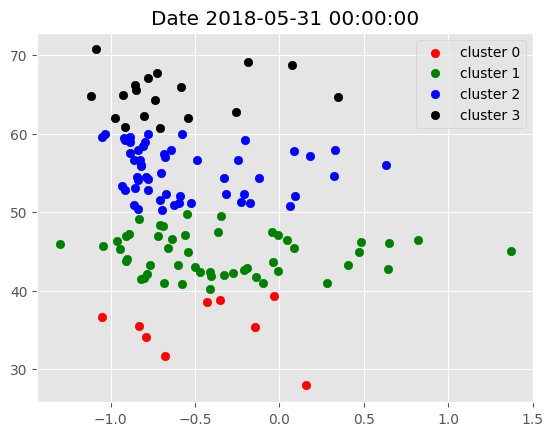

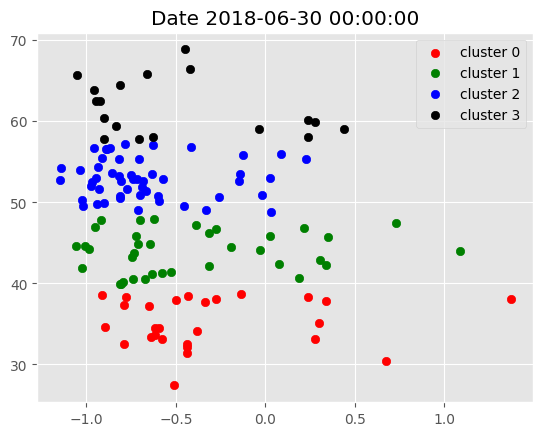

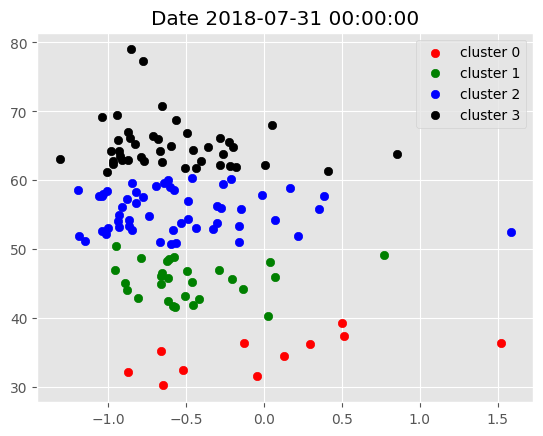

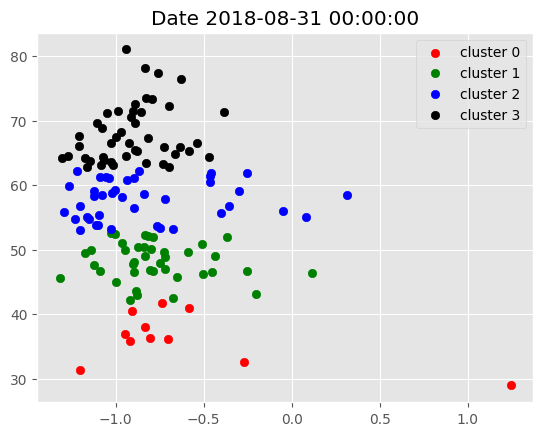

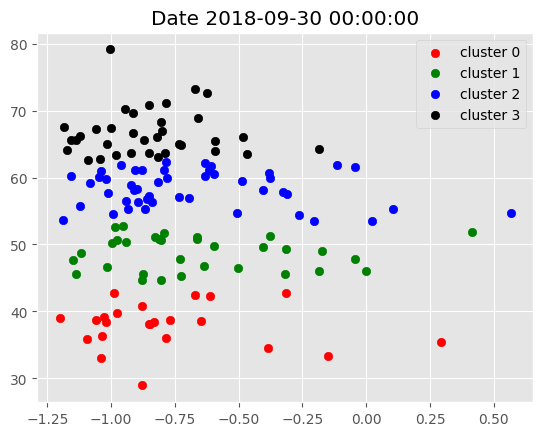

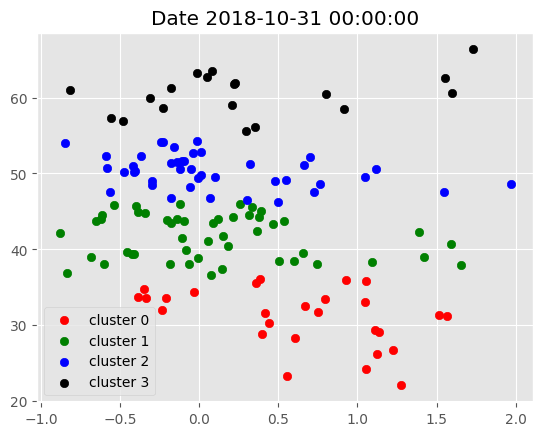

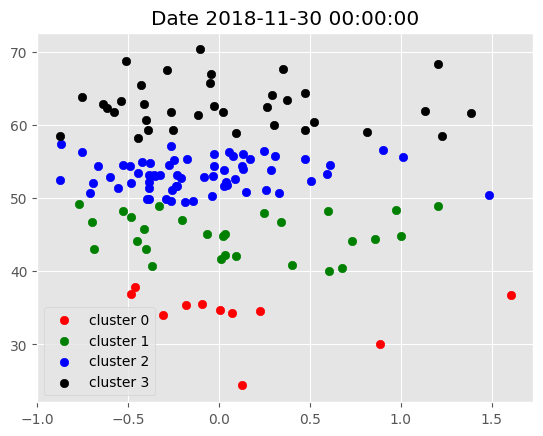

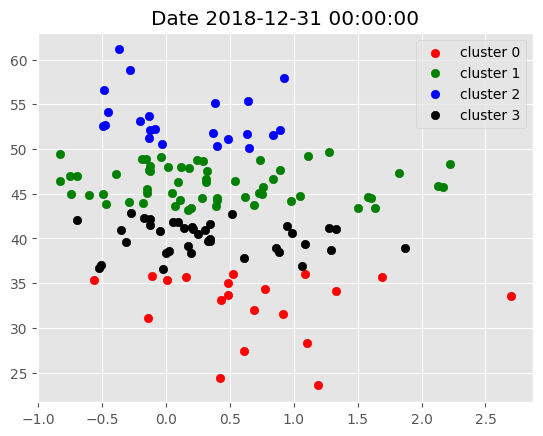

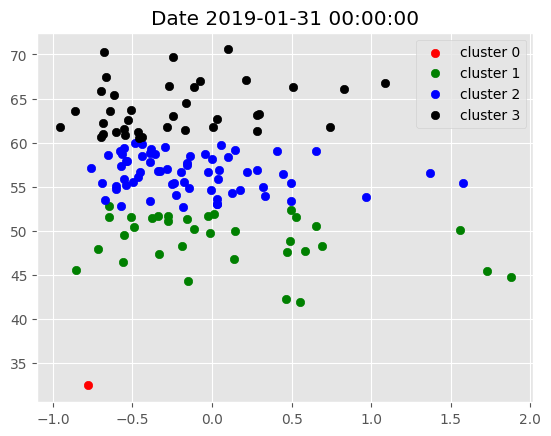

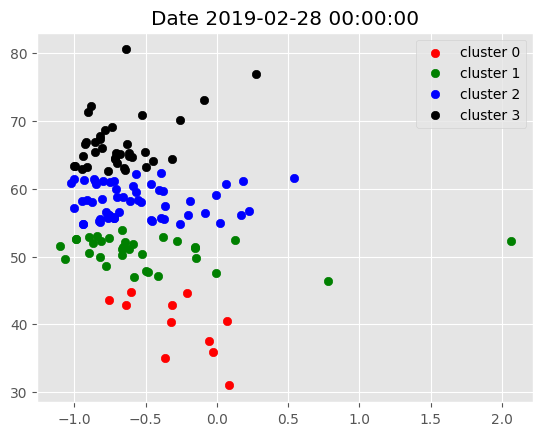

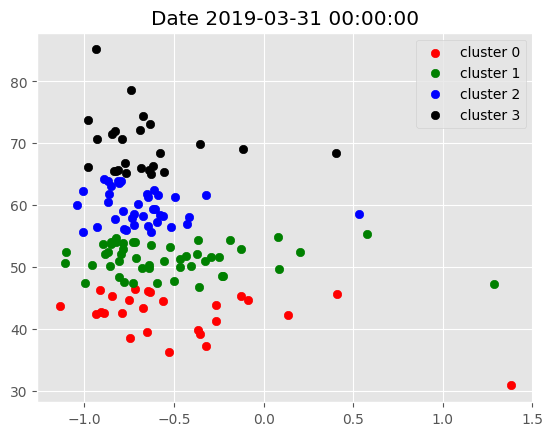

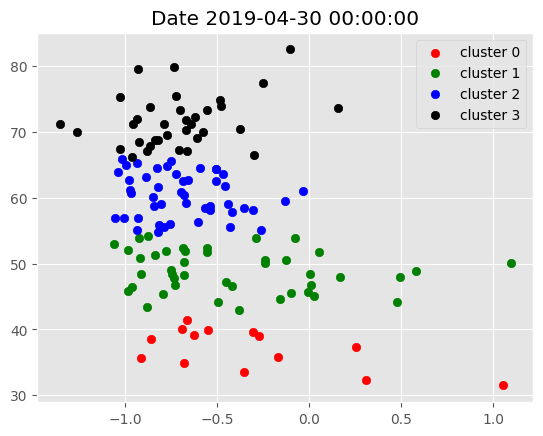

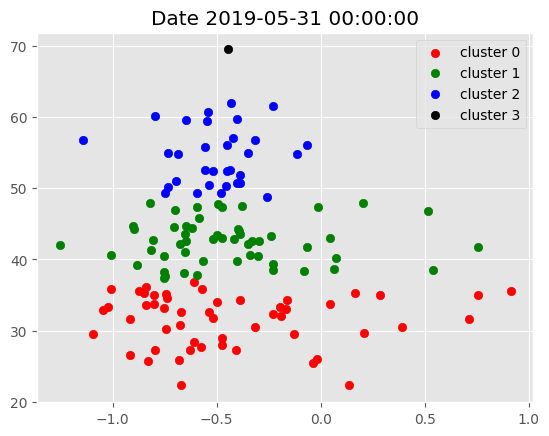

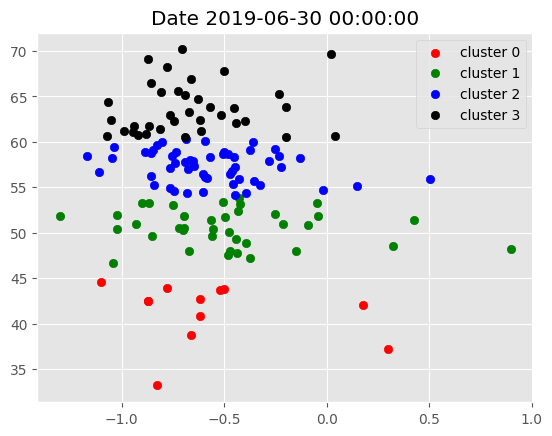

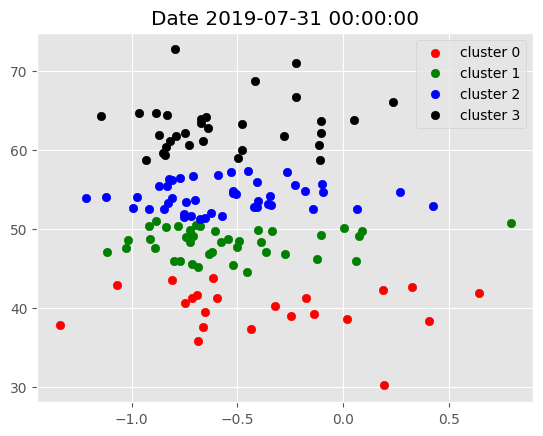

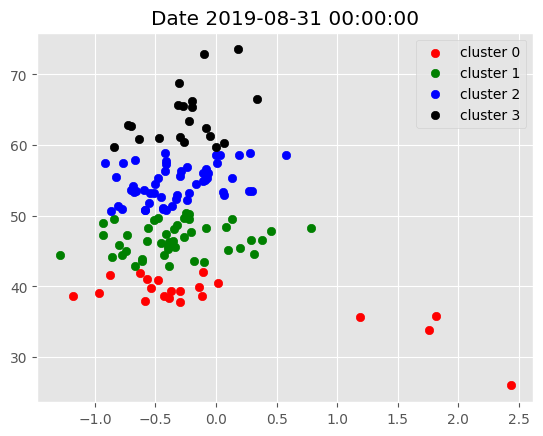

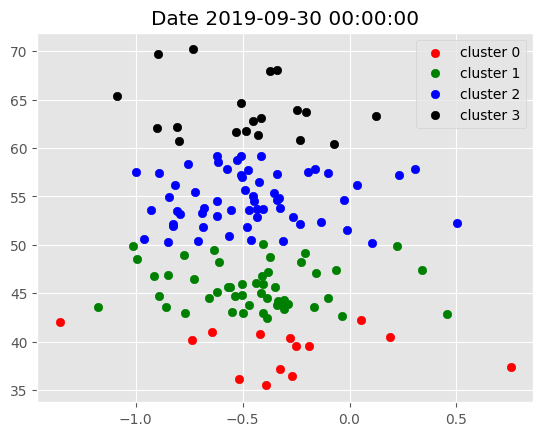

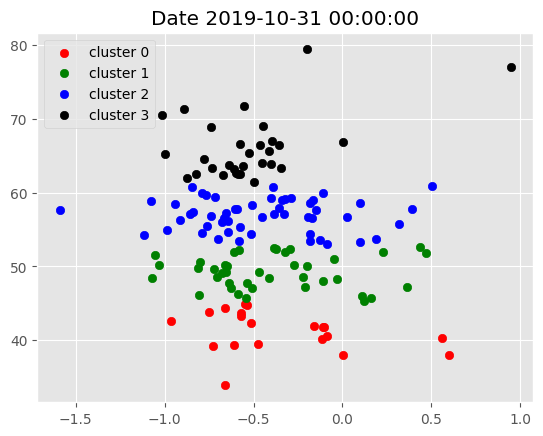

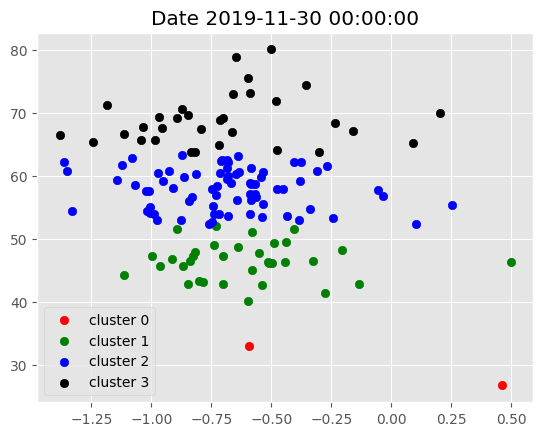

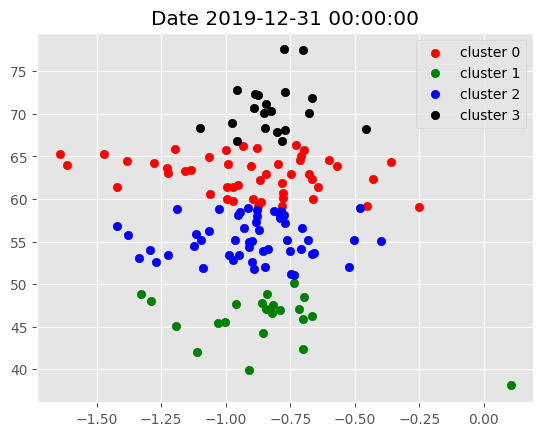

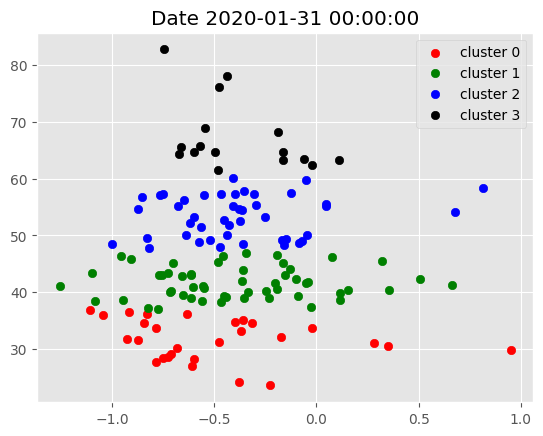

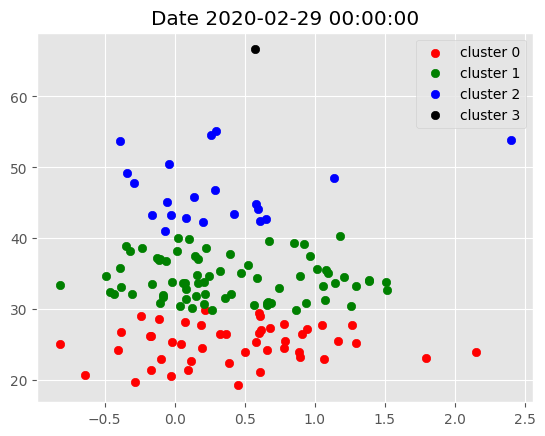

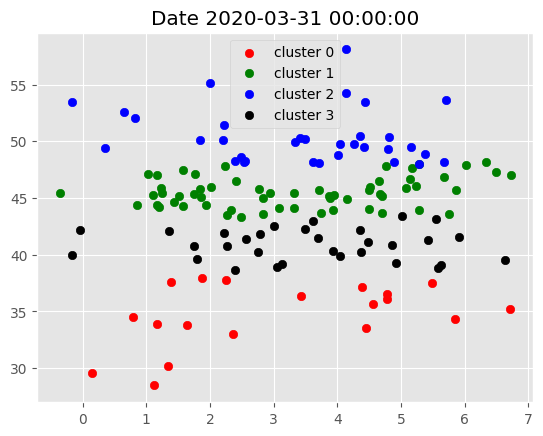

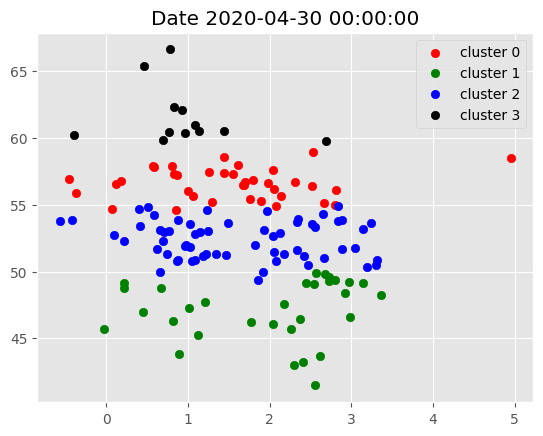

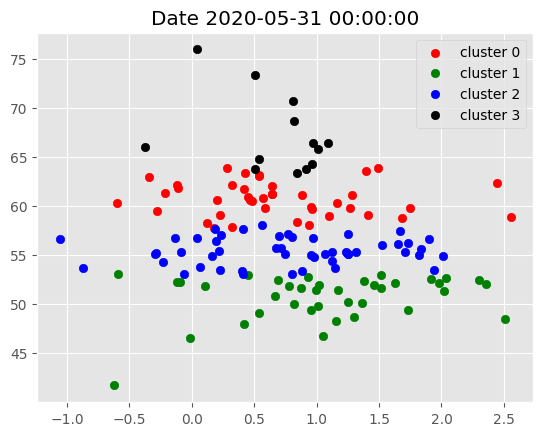

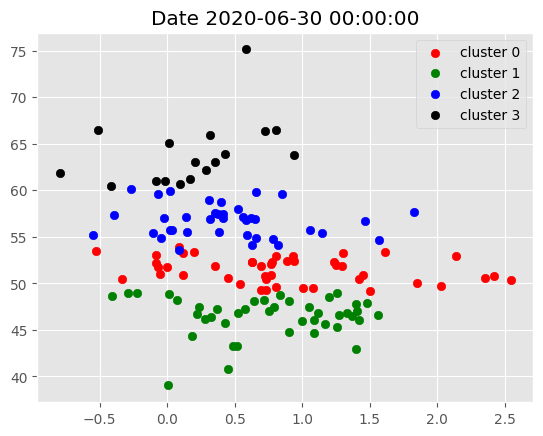

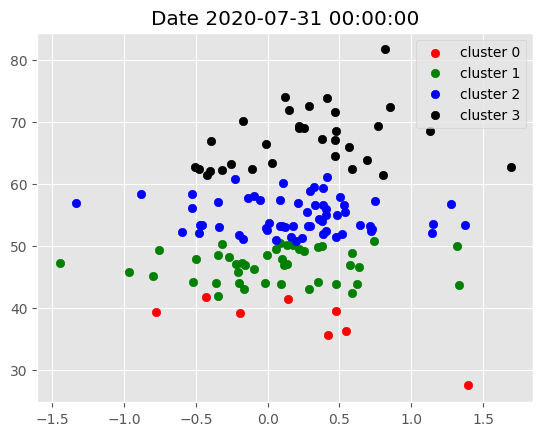

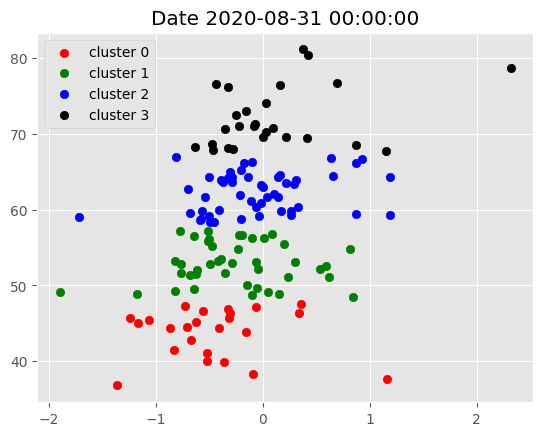

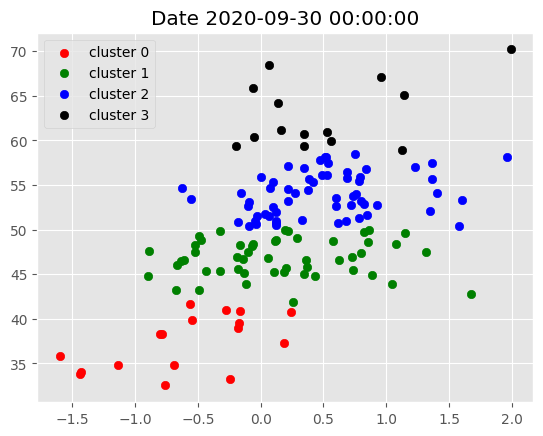

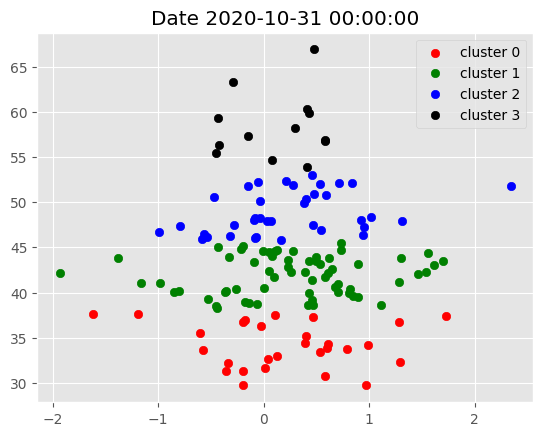

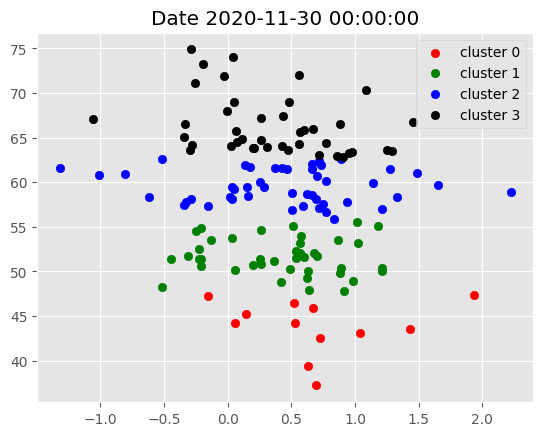

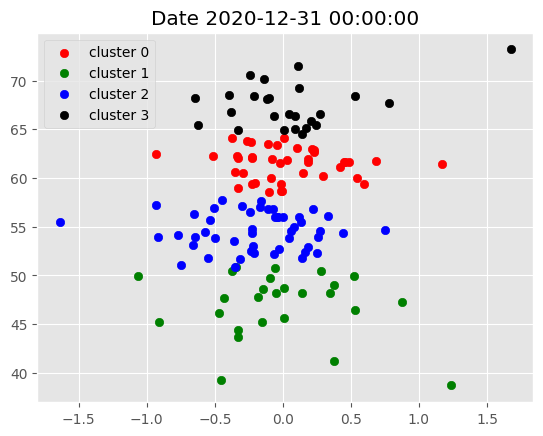

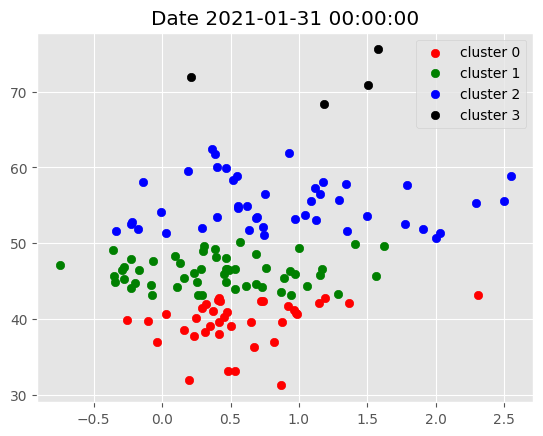

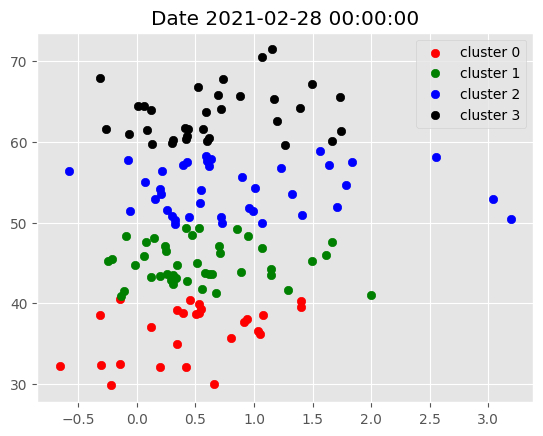

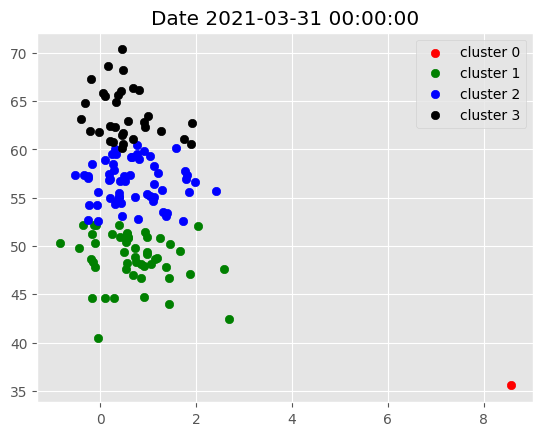

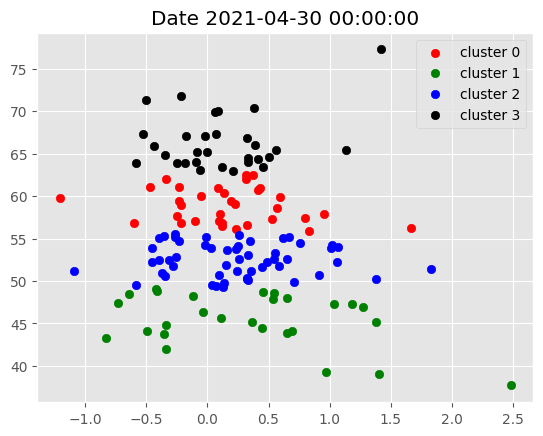

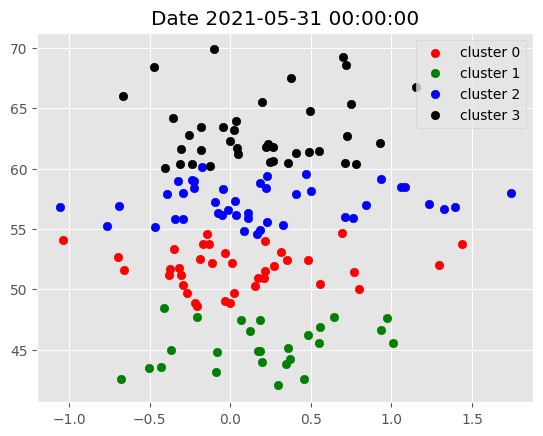

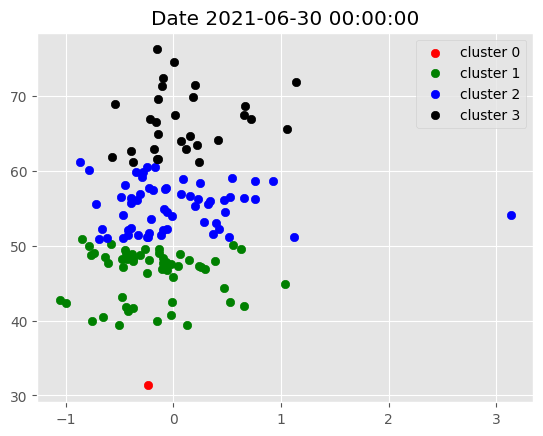

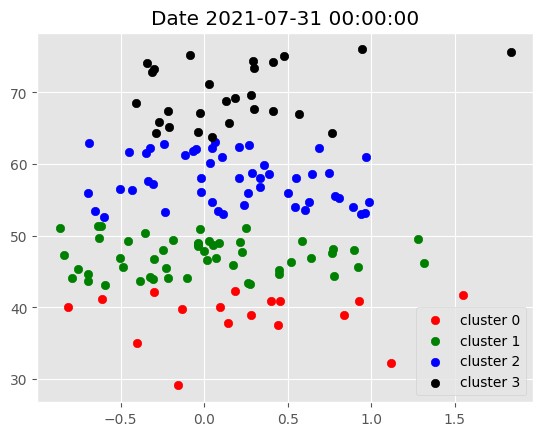

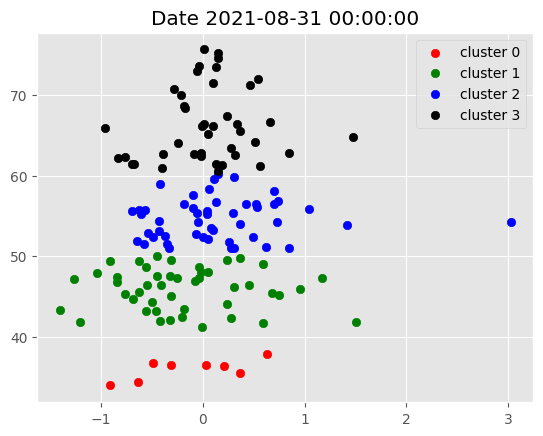

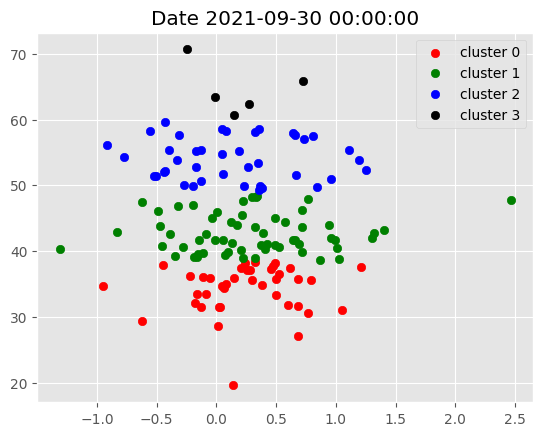

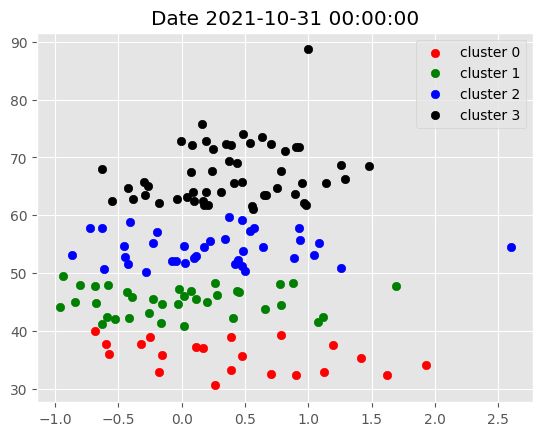

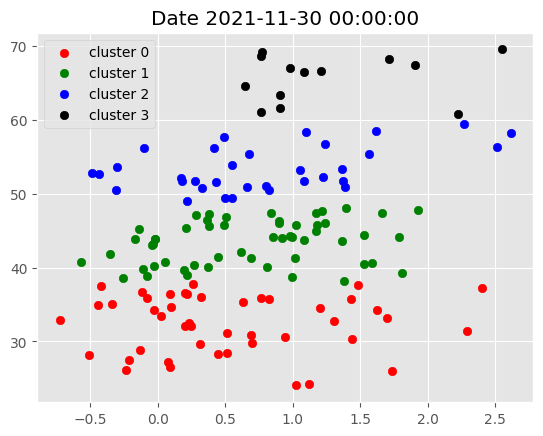

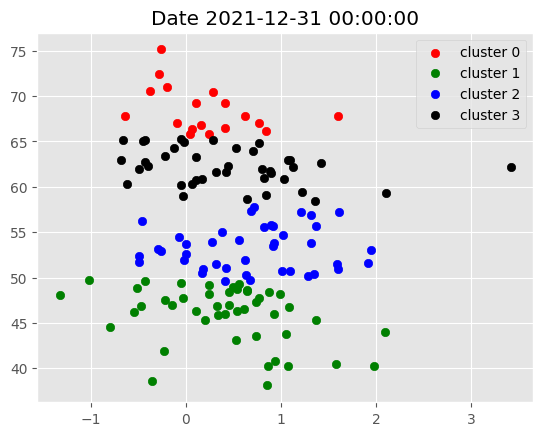

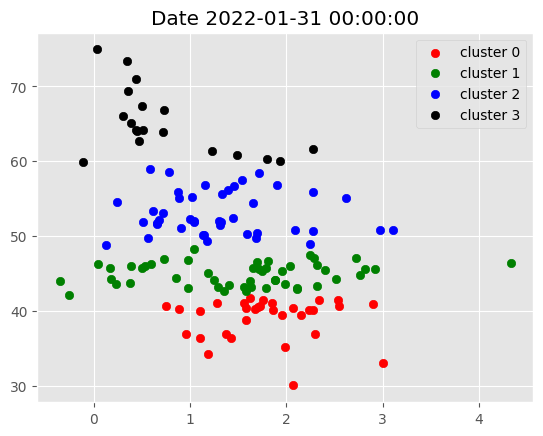

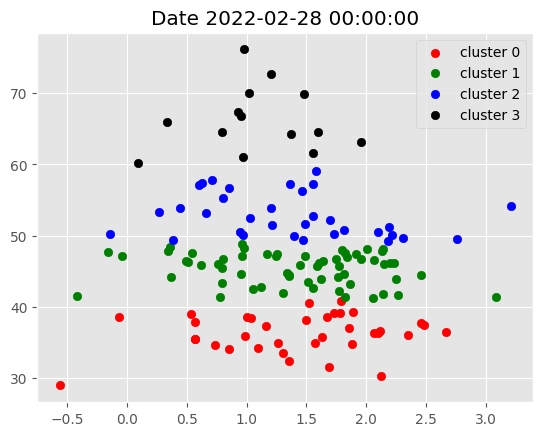

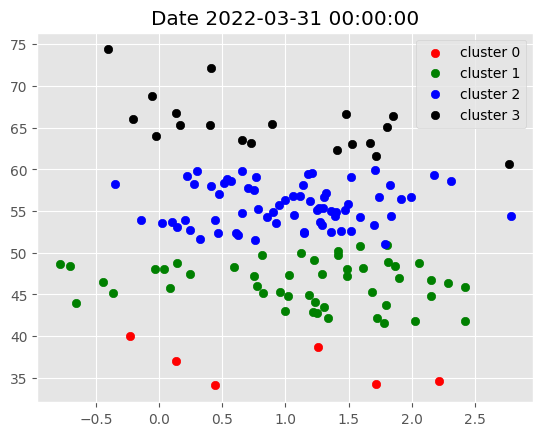

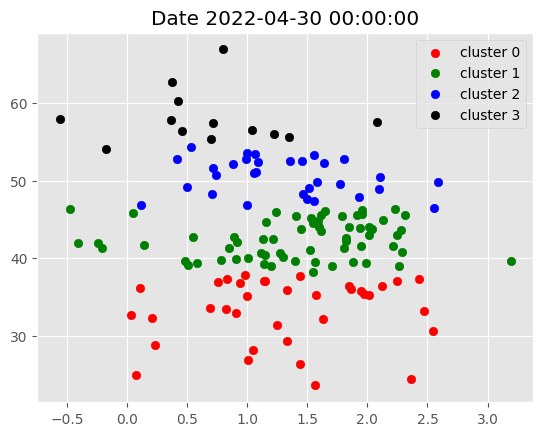

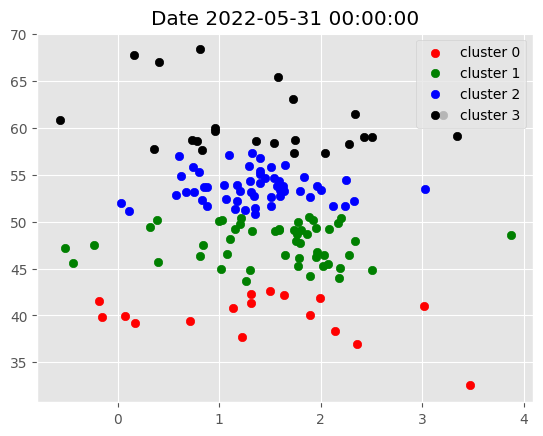

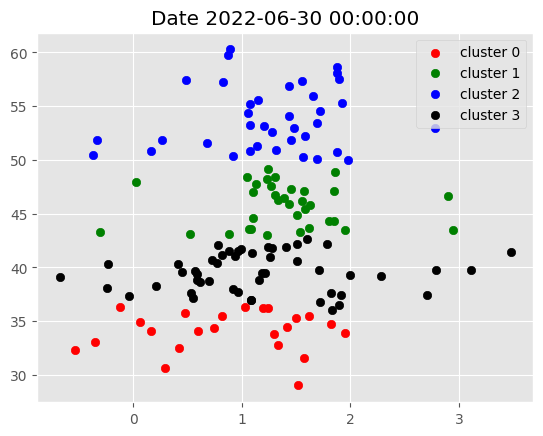

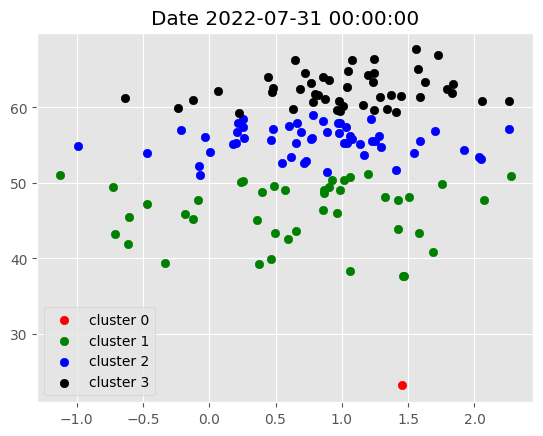

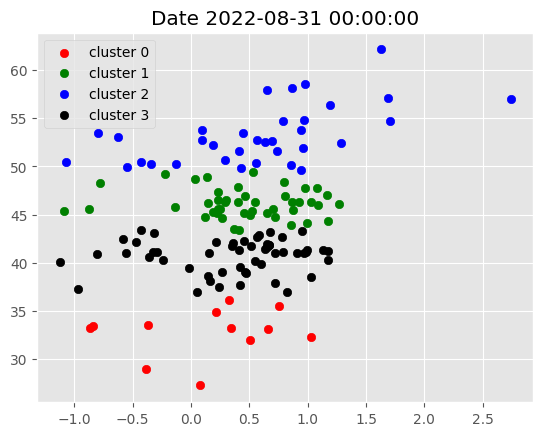

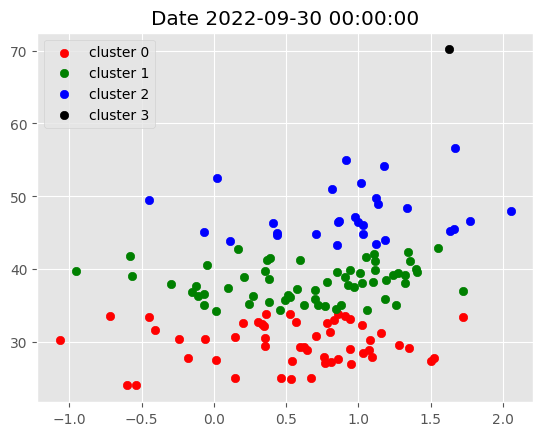

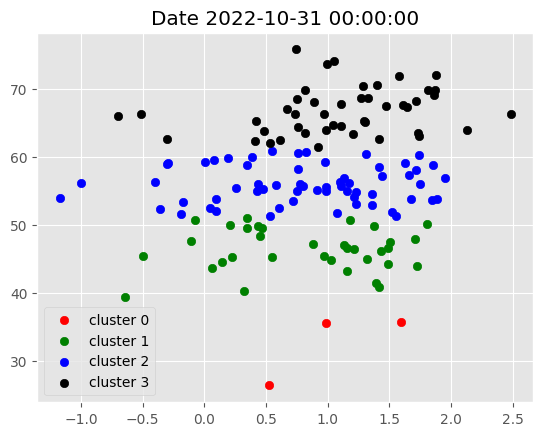

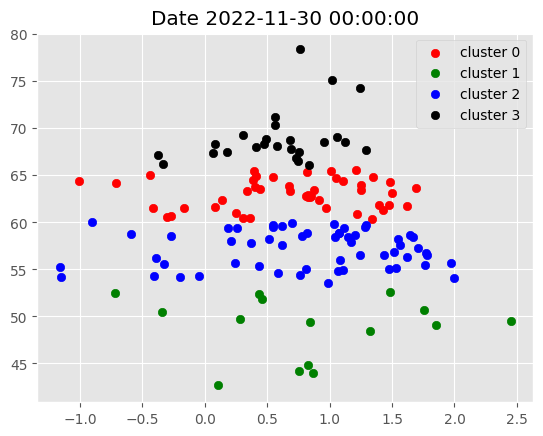

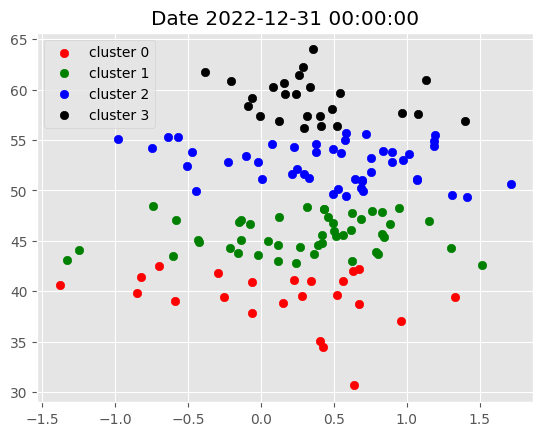

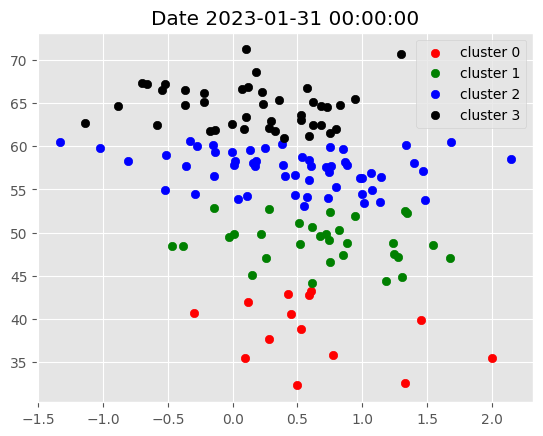

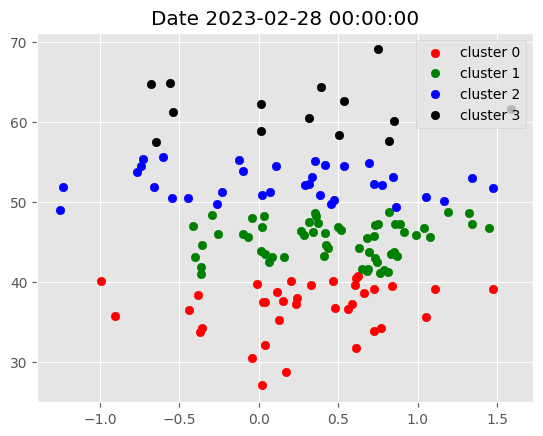

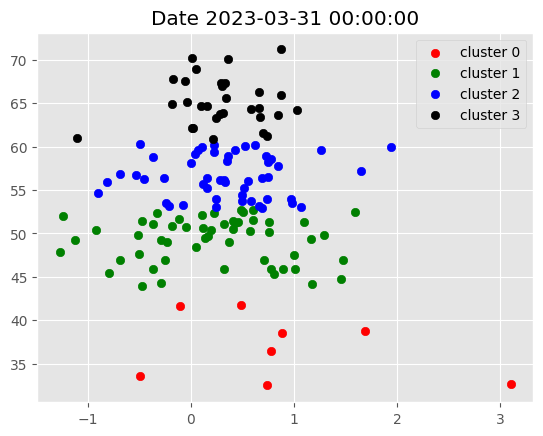

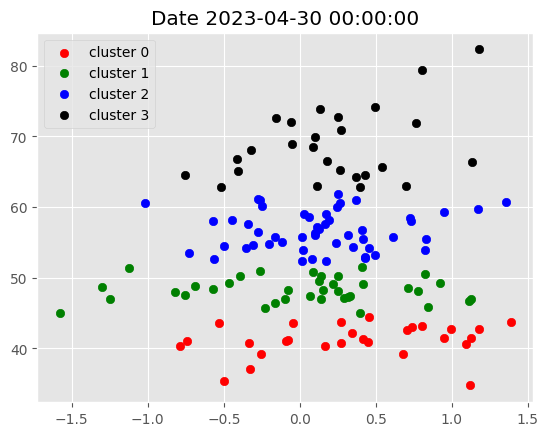

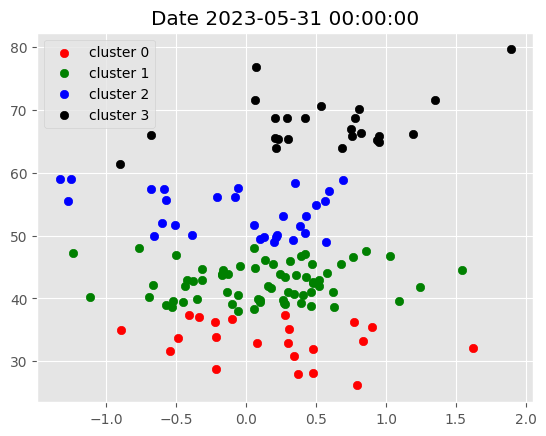

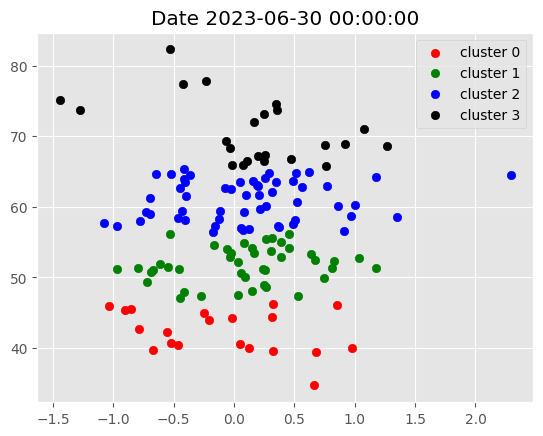

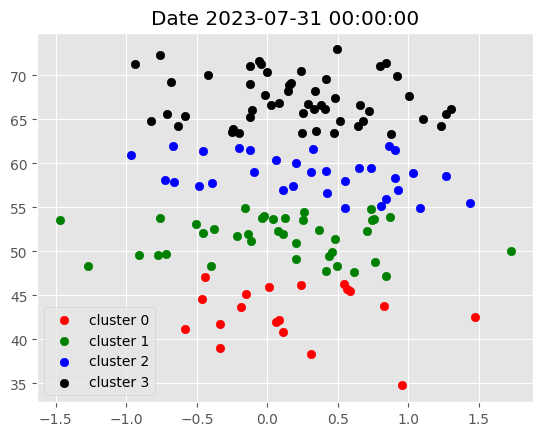

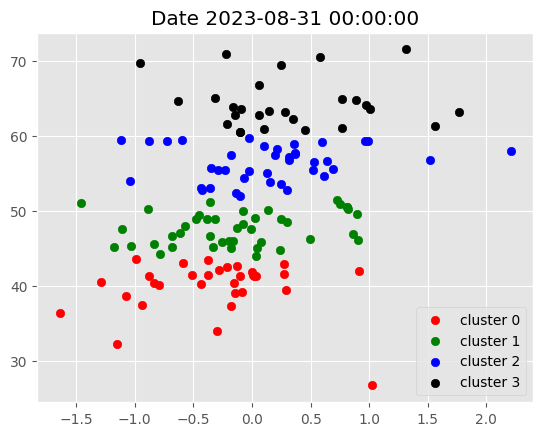

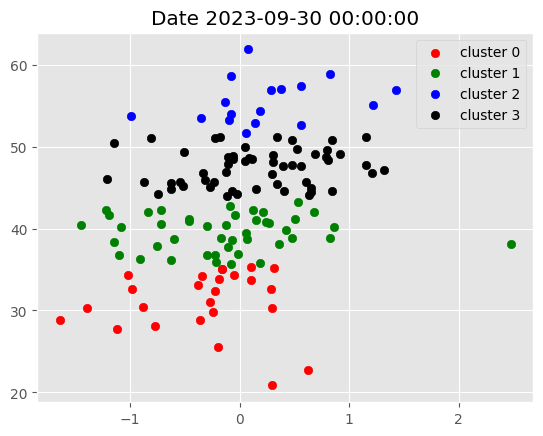

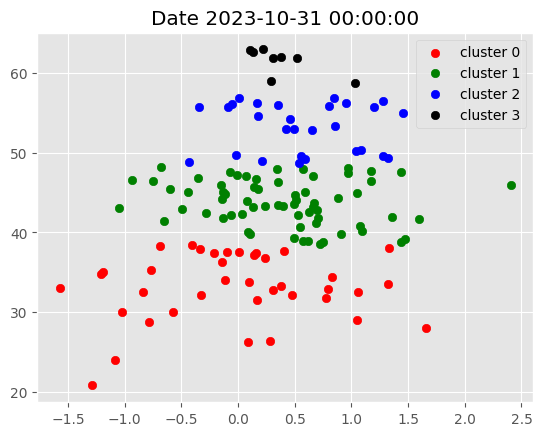

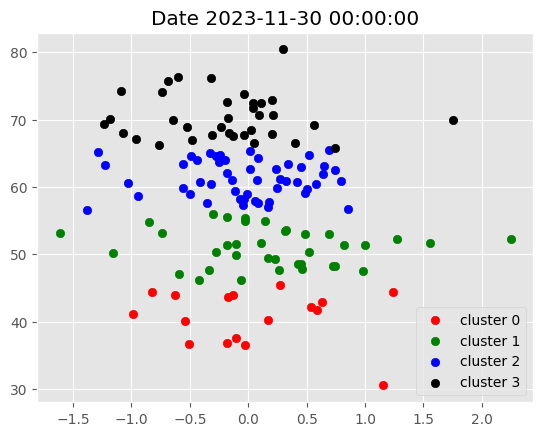

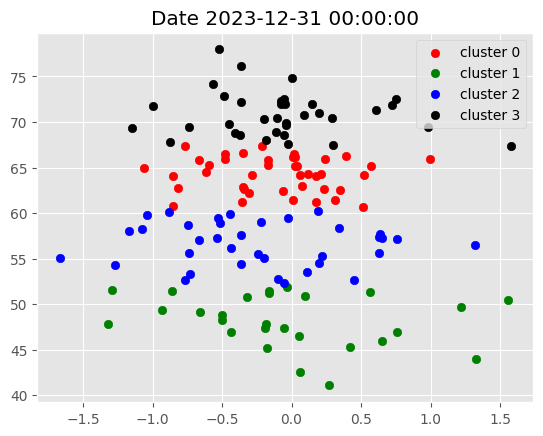

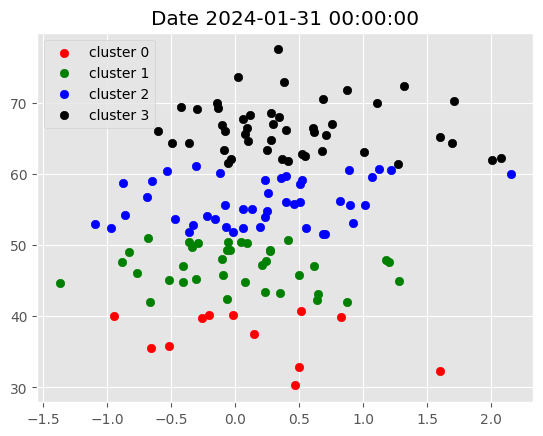

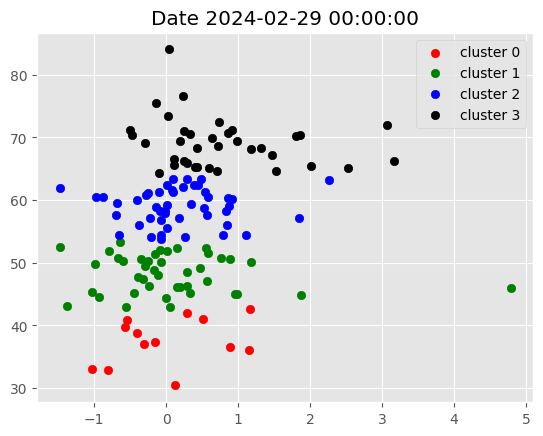

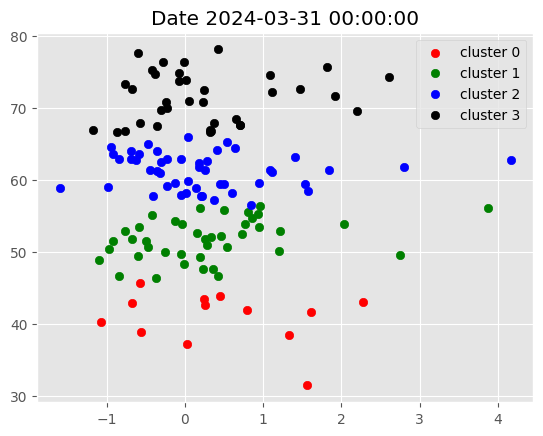

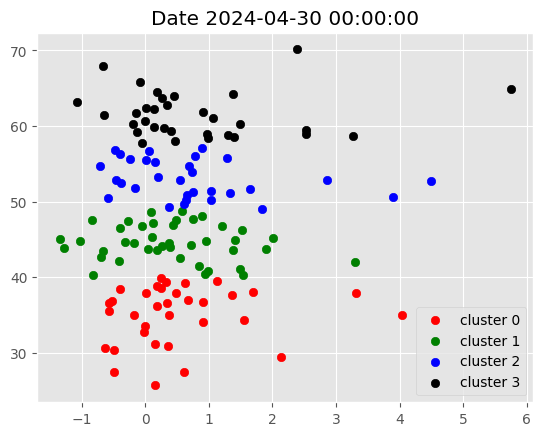

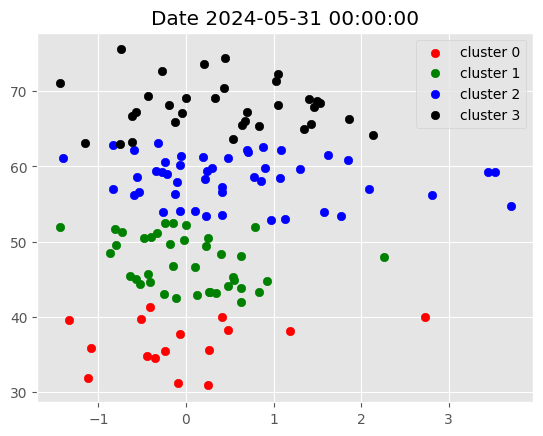

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MPC',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'BSX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  '

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-31  46.985195   35.748722   48.592537   40.407570  112.053131   
2017-06-01  47.606354   35.847015   49.100403   40.796959  112.791328   
2017-06-02  48.062527   36.378254   49.497849   41.150940  113.196419   
2017-06-05  48.276054   36.022530   49.689220   41.257137  113.952621   
2017-06-06  48.276054   36.144222   49.954201   41.027042  113.727577   
...               ...         ...         ...         ...         ...   
2024-05-23  13.820000  186.880005  158.259995  104.230003  305.929993   
2024-05-24  13.840000  189.979996  157.059998  103.949997  300.989990   
2024-05-28  13.440000  189.990005  155.339996  101.949997  297.730011   
2024-05-29  11.620000  190.289993  154.789993  100.730003  293.769989   
2024-05-30  11.440000  191.289993  156.309998  101.739998  284.799988   

                                                                       ...  \
                  ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-05-31  141.860001   74.552032   88.320030  111.769997  52.853073  ...   
2017-06-01  141.380005   71.465988   89.165489  113.029999  53.077351  ...   
2017-06-02  143.479996   70.335892   87.120773  112.910004  53.359753  ...   
2017-06-05  143.589996   68.458191   87.224304  110.879997  53.019207  ...   
2017-06-06  143.029999   69.631760   87.310600  111.449997  52.587273  ...   
...                ...         ...         ...         ...        ...  ...   
2024-05-23  483.309998  233.630692  251.490005  215.160004  77.580002  ...   
2024-05-24  475.429993  231.588806  248.899994  214.889999  78.029999  ...   
2024-05-28  478.429993  232.515137  243.300003  210.449997  77.360001  ...   
2024-05-29  477.600006  227.246078  240.089996  208.509995  77.570000  ...   
2024-05-30  445.869995  229.088760  240.910004  199.929993  78.250000  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-05-31   9866000  4655900  2813600  22811100   4355600  5531700  30519700   
2017-06-01   8911900  3541400  3356300  14219400   3692500  3520300  21001800   
2017-06-02   8570200  2788900  2837100  18552800   3940900  3191100  19477300   
2017-06-05  14510500  3897100  2030000   8538200   2824000  4286100  13663800   
2017-06-06   7030300  2579800  1250600  11610500   6663800  3626200  14887500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-05-23   6115900  2251400  1554700  14105000  16012300  5393000  13056100   
2024-05-24   4339700  1794500  1050600  10418800  10541200  2743100   9912500   
2024-05-28   6212100  1912700  1379600  15071300  20137100  4779100  11276300   
2024-05-29   5469700  3774100   967300  17652000  21387700  7524500  12835000   
2024-05-30   4903100  3970100   975400  19636500  12134300  6287400  13584800   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-05-31  24605100  1697100  13572300  
2017-06-01  24459300  4059300   9884100  
2017-06-02  23989500  2293600  21687300  
2017-06-05  30437100  1423700  11527100  
2017-06-06  34577700  1892400  12208600  
...              ...      ...       ...  
2024-05-23  16222900  1465100  15979800  
2024-05-24  11793800  1035400  12211400  
2024-05-28  13349600  1812400  13978300  
2024-05-29  11538600  2367700  13902000  
2024-05-30  13053500  1219100  14692000  

[1762 rows x 930 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-06-01,0.009637
2018-06-04,0.005540
2018-06-05,0.000239
2018-06-06,0.001665
2018-06-07,-0.008104
...,...
2024-05-23,-0.005457
2024-05-24,0.005000
2024-05-28,-0.000927


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [18]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-06-01,0.009637,0.009769
2018-06-04,0.005540,0.004741
2018-06-05,0.000239,0.000727
2018-06-06,0.001665,0.008326
2018-06-07,-0.008104,-0.000108
...,...,...
2024-05-23,-0.005457,-0.007331
2024-05-24,0.005000,0.006595
2024-05-28,-0.000927,0.000699
2024-05-29,-0.010976,-0.007027


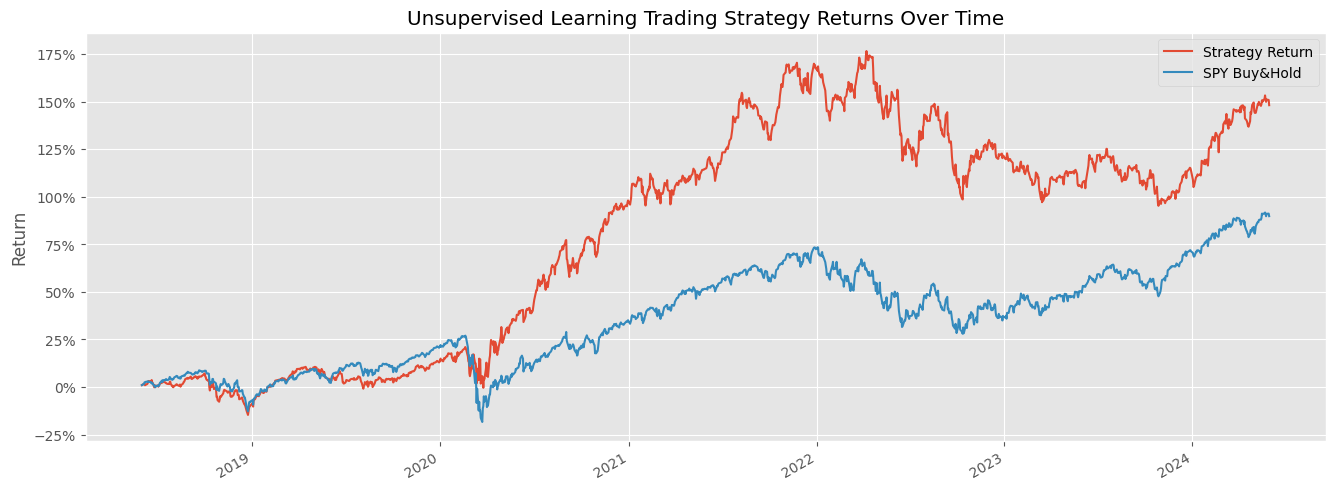

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-05-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
